# Biweekly Report 4
# Kyle, Carney
## Exploration of Resnet

In this Biweekly report I will compare the performance of a traditional Convolutional Neural Network and Residual Neural Networks. To this end, I will train a CNN, Resnet18, and a Resnet34 model from scratch to identify 12 species of mushrooms. Furthermore, I will compare the performance of RNNs trained from scratch and those pretrained on ImageNet. I find that the Resnet34 that was trained from scratch has the highest model accuracy.

## Background of Dataset

I am using the mushroom dataset curated by Dr. Boyuan Wang and available at [https://www.kaggle.com/mustai/mushroom-12-9528](https://www.kaggle.com/mustai/mushroom-12-9528). The dataset contains 9528 images of 12 different species of mushroom.  The accuracy of the data and labels has been confirmed by the Nordic Association of Mycologists. Previously studies have successfully used this dataset to train accurate models based on convolutional neural network architectures [https://doi.org/10.1155/2022/1173102](https://doi.org/10.1155/2022/1173102). Therefore, this dataset is accurate and of a high enough quality that it can be used to train my convolutional neural networks. This dataset is not fully balanced with Pluteus and Exidia being underrepresented.

In [1]:
#import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

In [2]:
#train and test data directory
data_dir = "Mushroom_data/train"
test_data_dir = "Mushroom_data/test"

## Data Augmentation

In my last biweekly report I found that the most effective augmentation methods are rotation, cropping and flipping.

In [3]:
train_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # rand crop
    transforms.RandomResizedCrop(150, scale=(0.9, 1.0)),
    # apply random rotation
    transforms.RandomRotation(degrees=360),
    # randomly apply flip
    transforms.RandomHorizontalFlip(p=0.5),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4078, 0.3866, 0.3004], [0.2473, 0.2273, 0.2279])
])


test_transform = transforms.Compose([
    # resize
    transforms.Resize((150,150)),
    # to-tensor
    transforms.ToTensor(),
    # make mean 0 and unit standard dev
    transforms.Normalize([0.4079, 0.3863, 0.2988], [0.2468, 0.2261, 0.2267])
])

In [4]:
train_dataset = ImageFolder(data_dir,train_transform)

test_dataset = ImageFolder(test_data_dir,test_transform)

## Split Data and Define Dataloaders

I will now split the full dataset into training and validation data. Since I am working with a relatively small dataset I reserve 20% of the data for validation.

In [5]:
val_size = int(np.floor(0.2 * len(train_dataset)))
train_size = len(train_dataset) - val_size

train_data,val_data = random_split(train_dataset,[train_size,val_size])


print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 6094
Length of Validation Data : 1523


In [6]:
batch_size = 64
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size * 2, num_workers=4, pin_memory=True)

## Model Definitions

This base includes standard functions all models will use.

In [7]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

This Residual Block will be used by the RNN networks.

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels = 150, out_channels = 12, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(out_channels)
        )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

This is the base Resnet model. We can initial instances of Resnet18 and Resnet34 by passing in different values for the layers.

In [9]:
class ResNet(ImageClassificationBase):
    def __init__(self, block, layers, num_classes = 12):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(64))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(5, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, xb):
        xb = self.conv1(xb)
        xb = self.maxpool(xb)
        xb = self.layer0(xb)
        xb = self.layer1(xb)
        xb = self.layer2(xb)
        xb = self.layer3(xb)

        xb = self.avgpool(xb)
        xb = xb.view(xb.size(0), -1)
        xb = self.fc(xb)

        return xb

I use a CNN with 6 convolutional layers and 3 fully connected layers. In order to increase accuracy and prevent overfitting I also use batch normalization and a 10% dropout between the convolution layers.

In [10]:
class CNN(ImageClassificationBase):

    def __init__(self):

        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.1),

            nn.Conv2d(128,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256 ,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.1),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,12)
        )

    def forward(self, xb):
        return self.network(xb)

## Load Data into Device

I will now define the functions and classes that will be used to set and load data into the device.

In [11]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Define Training Functions

These are standard model training functions.

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    acc_history = []

    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)


        acc_history.append(result)

    return acc_history

In [15]:
CNN6 = CNN().to(device)
Resnet18 = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
Resnet34 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

## Model Training
I will now train the model over 72 epochs. After several rounds of experimentation I found that this number of epochs yield the highest model accuracy while not allowing the model to overfit the data. I am using Adamax since my second biweekly report found this optimizer tends to preform very well on this dataset when the learning rate is 0.001.

In [16]:
#set the no. of epochs, optimizer function and learning rate
num_epochs = 72
opt_func = torch.optim.Adamax
lr = 0.001

In [17]:
#fitting the model on training data and record the result after each epoch
CNN_history = fit(num_epochs, lr, CNN6, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.2565, val_loss: 2.1162, val_acc: 0.3019
Epoch [1], train_loss: 2.0004, val_loss: 2.0580, val_acc: 0.3148
Epoch [2], train_loss: 1.9139, val_loss: 2.0488, val_acc: 0.3458
Epoch [3], train_loss: 1.8198, val_loss: 1.8844, val_acc: 0.3662
Epoch [4], train_loss: 1.7558, val_loss: 1.8456, val_acc: 0.3774
Epoch [5], train_loss: 1.6766, val_loss: 1.8081, val_acc: 0.3978
Epoch [6], train_loss: 1.6132, val_loss: 1.8620, val_acc: 0.3965
Epoch [7], train_loss: 1.5929, val_loss: 1.7823, val_acc: 0.4075
Epoch [8], train_loss: 1.5318, val_loss: 1.7219, val_acc: 0.4081
Epoch [9], train_loss: 1.4626, val_loss: 1.7627, val_acc: 0.4352
Epoch [10], train_loss: 1.4339, val_loss: 1.7490, val_acc: 0.4132
Epoch [11], train_loss: 1.3903, val_loss: 1.6879, val_acc: 0.4363
Epoch [12], train_loss: 1.3336, val_loss: 1.6939, val_acc: 0.4428
Epoch [13], train_loss: 1.3103, val_loss: 1.6847, val_acc: 0.4525
Epoch [14], train_loss: 1.2542, val_loss: 1.6335, val_acc: 0.4548
Epoch [15], train_lo

In [18]:
#fitting the model on training data and record the result after each epoch
Resnet18_history = fit(num_epochs, lr, Resnet18, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.2320, val_loss: 2.0483, val_acc: 0.2919
Epoch [1], train_loss: 1.9795, val_loss: 2.1070, val_acc: 0.3014
Epoch [2], train_loss: 1.8907, val_loss: 2.0027, val_acc: 0.3354
Epoch [3], train_loss: 1.8282, val_loss: 2.0293, val_acc: 0.3137
Epoch [4], train_loss: 1.7622, val_loss: 1.9220, val_acc: 0.3472
Epoch [5], train_loss: 1.7091, val_loss: 1.8595, val_acc: 0.3881
Epoch [6], train_loss: 1.6689, val_loss: 1.8055, val_acc: 0.3900
Epoch [7], train_loss: 1.6320, val_loss: 1.7385, val_acc: 0.4179
Epoch [8], train_loss: 1.5874, val_loss: 1.7817, val_acc: 0.3908
Epoch [9], train_loss: 1.5597, val_loss: 1.7520, val_acc: 0.4049
Epoch [10], train_loss: 1.5170, val_loss: 1.7365, val_acc: 0.4227
Epoch [11], train_loss: 1.4856, val_loss: 1.6652, val_acc: 0.4533
Epoch [12], train_loss: 1.4566, val_loss: 1.5750, val_acc: 0.4553
Epoch [13], train_loss: 1.4267, val_loss: 1.6790, val_acc: 0.4564
Epoch [14], train_loss: 1.3737, val_loss: 1.6145, val_acc: 0.4656
Epoch [15], train_lo

In [19]:
#fitting the model on training data and record the result after each epoch
Resnet34_history = fit(num_epochs, lr, Resnet34, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3183, val_loss: 2.2068, val_acc: 0.2445
Epoch [1], train_loss: 2.0730, val_loss: 2.1463, val_acc: 0.3060
Epoch [2], train_loss: 1.9860, val_loss: 1.9865, val_acc: 0.3277
Epoch [3], train_loss: 1.9271, val_loss: 2.0464, val_acc: 0.3022
Epoch [4], train_loss: 1.8558, val_loss: 2.0591, val_acc: 0.3406
Epoch [5], train_loss: 1.8142, val_loss: 1.8951, val_acc: 0.3725
Epoch [6], train_loss: 1.7793, val_loss: 1.8647, val_acc: 0.3580
Epoch [7], train_loss: 1.7600, val_loss: 1.8445, val_acc: 0.3879
Epoch [8], train_loss: 1.7129, val_loss: 1.8675, val_acc: 0.3738
Epoch [9], train_loss: 1.7007, val_loss: 1.7651, val_acc: 0.4163
Epoch [10], train_loss: 1.6543, val_loss: 1.8808, val_acc: 0.3765
Epoch [11], train_loss: 1.6247, val_loss: 1.8263, val_acc: 0.3908
Epoch [12], train_loss: 1.6281, val_loss: 1.9175, val_acc: 0.3658
Epoch [13], train_loss: 1.5870, val_loss: 1.7422, val_acc: 0.4402
Epoch [14], train_loss: 1.5686, val_loss: 1.7840, val_acc: 0.4086
Epoch [15], train_lo

## Results
I will now consider how the validation accuracy varies by model.

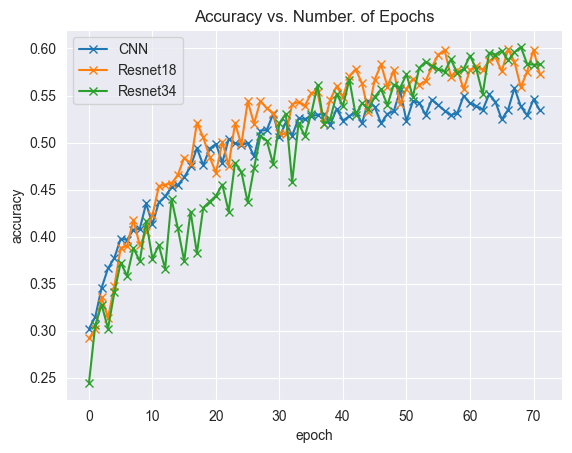

In [20]:
def plot_accuracies(history1, history2, history3):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history1]
    plt.plot(accuracies, '-x', label = 'CNN')
    accuracies = [x['val_acc'] for x in history2]
    plt.plot(accuracies, '-x', label = 'Resnet18')
    accuracies = [x['val_acc'] for x in history3]
    plt.plot(accuracies, '-x', label = 'Resnet34')


    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. Number. of Epochs');
    plt.legend()
    plt.rcParams["figure.figsize"] = (12,8)

plot_accuracies(CNN_history, Resnet18_history,Resnet34_history)

These results suggest that Resnet18 and Resnet34 perform marginally better than the standard CNN with Resnet34 having a max accuracy of about 0.6.

## Pretrained

I will now consider the performance of RNNs that are pretrained on ImageNet. I use the weights from [https://download.pytorch.org/models/resnet34-b627a593.pth]( https://download.pytorch.org/models/resnet34-b627a593.pth) and follow the tutorial from [https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [21]:
image_datasets = [train_dataset, test_dataset]
dataloaders = [ train_dl, val_dl ]
dataset_sizes = [len(train_data), len(val_data)]
class_names = image_datasets[0].classes

## Training function
This function will train the model and track the best validation accuracy. Note, this code uses a scheduler function to change the learning rate as the number of epochs increases.

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [0,1]:
            if phase == 0:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 0):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 0:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 0:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 0:
                print(f' Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            else:
                print(f' Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                acc_history.append(epoch_acc)

            #print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # deep copy the model
            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history

## Load pretrained models

I couldn't download the model weights directly through pycharm so I instead downloaded manually and added them to my local repository.

In [23]:
import time
import copy
import torchvision.models as models

pretrained_resnet18 = models.resnet18().to(device)

PATH = 'resnet18-f37072fd.pth'
state = {'model': pretrained_resnet18.state_dict()}
torch.save(state, PATH)
pretrained_resnet18.load_state_dict(torch.load(PATH)['model'])


pretrained_resnet34 = models.resnet34().to(device)

PATH = 'resnet34-b627a593.pth'
state = {'model': pretrained_resnet34.state_dict()}
torch.save(state, PATH)
pretrained_resnet34.load_state_dict(torch.load(PATH)['model'])

<All keys matched successfully>

## Adjust fully connected layer
I will now adjust the fully connected layers so this model is fitted for 12 classes.

In [24]:
class mushroom_model(nn.Module):
    def __init__(self):
        super().__init__()
        #nn.Linear(1024, 512)
        self.linear1=nn.Linear(512,256)
        self.linear2=nn.Linear(256,12)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [25]:
model_ = mushroom_model().to(device)

In [26]:
pretrained_resnet18.fc = model_
pretrained_resnet18 = pretrained_resnet18.to(device)

pretrained_resnet34.fc = model_
pretrained_resnet34 = pretrained_resnet34.to(device)

pretrained_resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train model

I will now train the pretrained models with the mushroom data.

In [27]:
num_epochs = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(pretrained_resnet34.parameters(), lr = 0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=66, gamma=0.1)

In [28]:
pt_resnet18_model_ft, pt_resnet18_history = train_model(pretrained_resnet18, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/199
----------
 Training Loss: 2.5771 Acc: 0.1359
 Validation Loss: 2.4297 Acc: 0.1293

Epoch 1/199
----------
 Training Loss: 2.4145 Acc: 0.1585
 Validation Loss: 2.4226 Acc: 0.1300

Epoch 2/199
----------
 Training Loss: 2.4005 Acc: 0.1611
 Validation Loss: 2.4069 Acc: 0.1379

Epoch 3/199
----------
 Training Loss: 2.3810 Acc: 0.1670
 Validation Loss: 2.3796 Acc: 0.1445

Epoch 4/199
----------
 Training Loss: 2.3582 Acc: 0.1759
 Validation Loss: 2.3745 Acc: 0.1622

Epoch 5/199
----------
 Training Loss: 2.3414 Acc: 0.1748
 Validation Loss: 2.3336 Acc: 0.1536

Epoch 6/199
----------
 Training Loss: 2.3120 Acc: 0.1958
 Validation Loss: 2.3178 Acc: 0.1825

Epoch 7/199
----------
 Training Loss: 2.3022 Acc: 0.1977
 Validation Loss: 2.2845 Acc: 0.1944

Epoch 8/199
----------
 Training Loss: 2.2891 Acc: 0.2096
 Validation Loss: 2.3482 Acc: 0.1694

Epoch 9/199
----------
 Training Loss: 2.2962 Acc: 0.2025
 Validation Loss: 2.2746 Acc: 0.1976

Epoch 10/199
----------
 Training Loss: 

In [29]:
pt_resnet34_model_ft, pt_resnet34_history = train_model(pretrained_resnet34, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/199
----------
 Training Loss: 2.4992 Acc: 0.1390
 Validation Loss: 2.4946 Acc: 0.1346

Epoch 1/199
----------
 Training Loss: 2.4060 Acc: 0.1651
 Validation Loss: 2.4613 Acc: 0.1582

Epoch 2/199
----------
 Training Loss: 2.3516 Acc: 0.1805
 Validation Loss: 2.3493 Acc: 0.2049

Epoch 3/199
----------
 Training Loss: 2.3146 Acc: 0.2043
 Validation Loss: 2.3437 Acc: 0.1793

Epoch 4/199
----------
 Training Loss: 2.2941 Acc: 0.2015
 Validation Loss: 2.3124 Acc: 0.1911

Epoch 5/199
----------
 Training Loss: 2.2718 Acc: 0.2143
 Validation Loss: 2.3101 Acc: 0.1944

Epoch 6/199
----------
 Training Loss: 2.2563 Acc: 0.2212
 Validation Loss: 2.2984 Acc: 0.1924

Epoch 7/199
----------
 Training Loss: 2.2476 Acc: 0.2265
 Validation Loss: 2.2897 Acc: 0.2108

Epoch 8/199
----------
 Training Loss: 2.2304 Acc: 0.2291
 Validation Loss: 2.2610 Acc: 0.2141

Epoch 9/199
----------
 Training Loss: 2.2249 Acc: 0.2325
 Validation Loss: 2.2423 Acc: 0.2167

Epoch 10/199
----------
 Training Loss: 

## Results

I will now compare the validation accuracies of these two models.

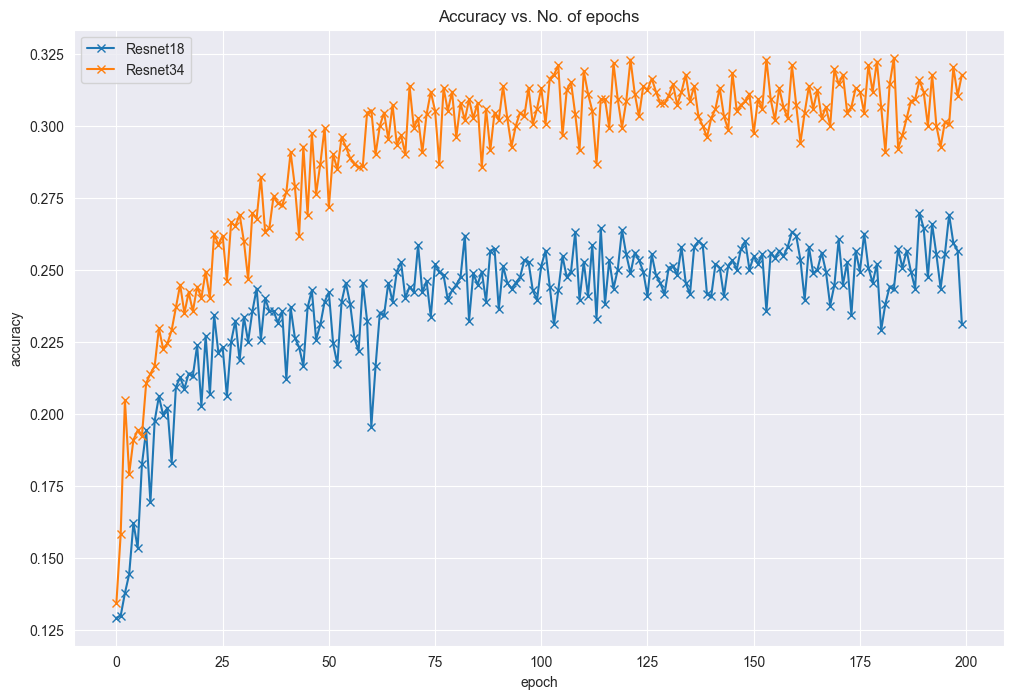

In [30]:
def plot_accuracies(history1,history2):
    """ Plot the history of accuracies"""
    accuracies = []
    for i in range(num_epochs):
        accuracies.append(history1[i].item())
    plt.plot(accuracies, '-x', label = 'Resnet18')

    accuracies = []
    for i in range(num_epochs):
        accuracies.append(history2[i].item())
    plt.plot(accuracies, '-x', label = 'Resnet34')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.legend()
    plt.rcParams["figure.figsize"] = (12,4)

plot_accuracies(pt_resnet18_history,pt_resnet34_history)

Resnet34 trained faster and at a higher accuracy than Resnet18. However, the accuracy of both models leveled out after 100 epochs.

## Comparison of Resnet34 models

The pretrained Resnet34 greatly underperformed compared to the scratch Resnet34 model. The scratch model had a highest accuracy of about 0.6 while the pretrained model had a maximum accuracy of 0.34. I will now use confusion matrices to explore why these models have different accuracies.

In [31]:
test_dl = DataLoader(test_dataset, 2*batch_size, num_workers = 4, pin_memory = True)
test_dl = DeviceDataLoader(test_dl, device)


from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for images, labels in test_dl:
        output = Resnet34(images) # Feed Model

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


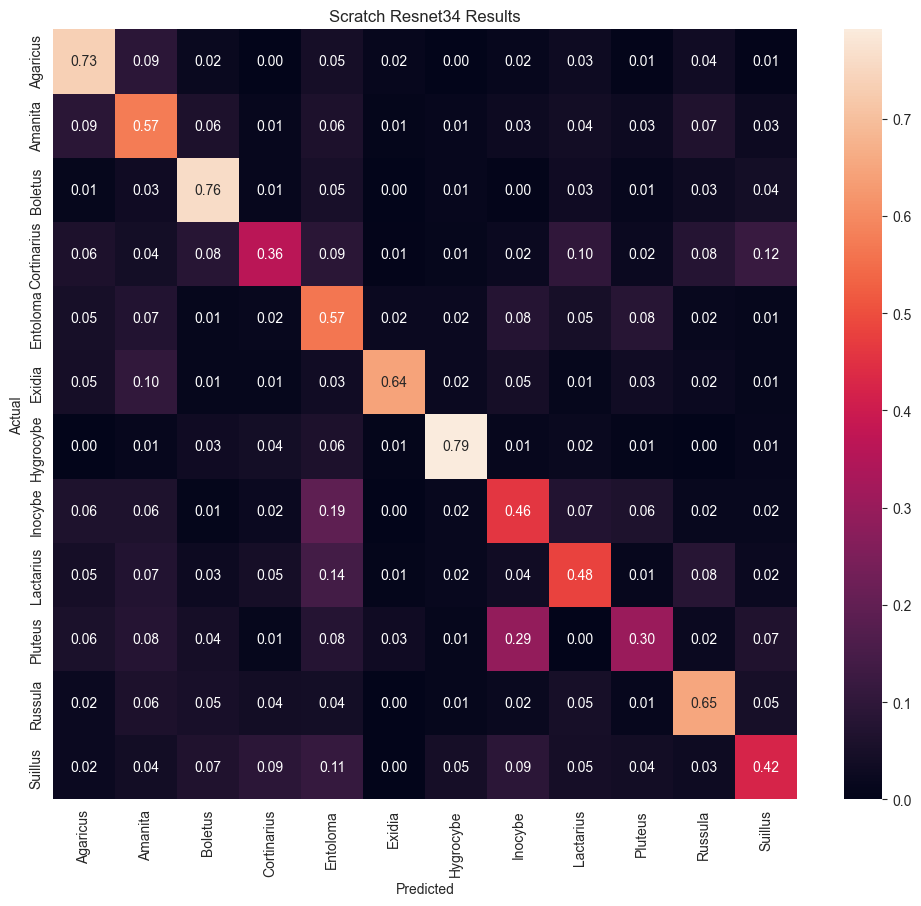

In [32]:
# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize
cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12,10))

sn.heatmap(cmn, annot = True, fmt = '.2f', xticklabels= class_names, yticklabels= class_names )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Scratch Resnet34 Results')
plt.show(block = False)

The resnet model generally performs on most of the classes. However, it has trouble telling the difference between Pluteus, Inocybe, and Entoloma.

In [33]:
test_dl = DataLoader(test_dataset, 2*batch_size, num_workers = 4, pin_memory = True)
test_dl = DeviceDataLoader(test_dl, device)


from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for images, labels in test_dl:
        output = pt_resnet34_model_ft(images) # Feed Model

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


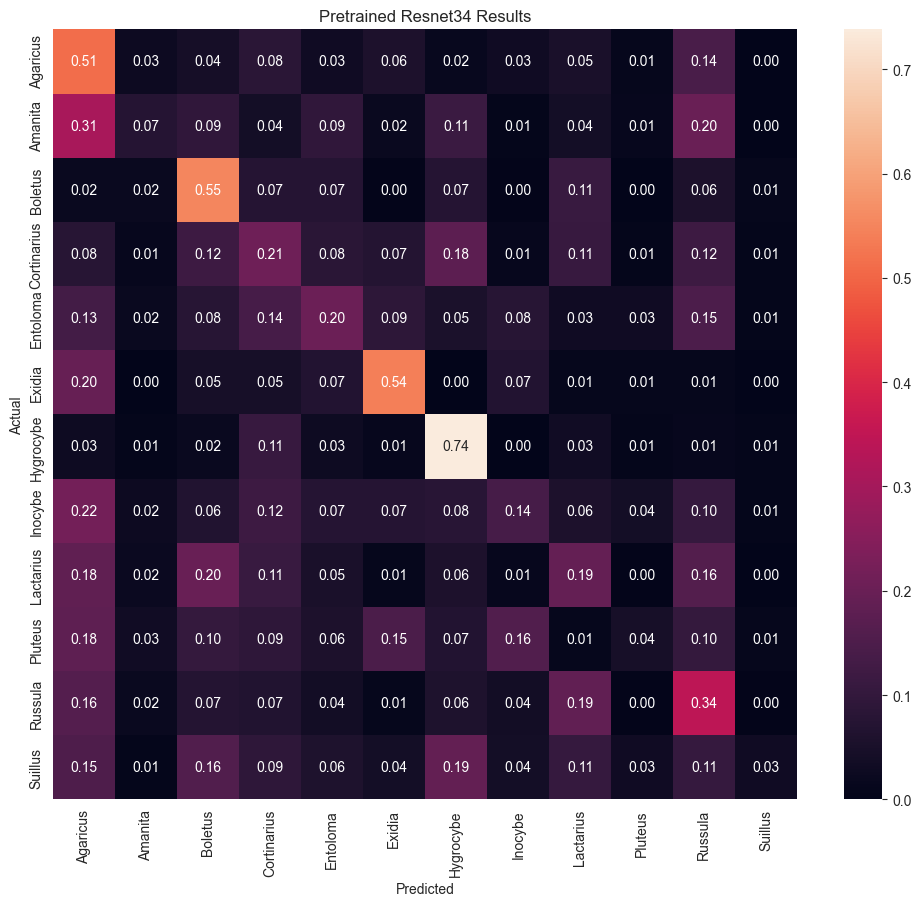

In [34]:
# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize
cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12,10))

sn.heatmap(cmn, annot = True, fmt = '.2f', xticklabels= class_names, yticklabels= class_names )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Pretrained Resnet34 Results')
plt.show(block = False)

These results suggest that the pretrained model is biased in favor of a few classes. For example, it overguesses Agarius, Cortinarius, and Entoloma.

## Conclusion

In this report I explored how well Resnet18 and Resnet34 can model identify mushroom species. I found that Resnet34 can marginally outperform a six layer CNN model when trained from scratch. Furthermore, I found that the models trained from scratch outperformed the models pretrained on Imagenet. I was surprised to see this as I thought the pretrained models would be better suited to identify and classify mushrooms since Imagenet has a mushroom class. I had hoped that since the pretrained models have already been trained to identify mushrooms I would be able to train them to identify the more nuanced differences between the species. In the future I would like to continue to explore transfer learning by using models that have been pretrained on different datasets which may yield higher accuracies.